In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from math import pi
from math import exp
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import time
import warnings
warnings.filterwarnings("ignore")

In [78]:
df = pd.read_csv("Maternal Health Risk Data Set.csv")

In [79]:
# df.loc[df['RiskLevel']=='high risk']

In [80]:
df.loc[df['RiskLevel']=='mid risk', 'RiskLevel'] = 'low risk'
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [81]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

In [82]:
df_test

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,23,120,90,7.5,98.0,70,low risk
1,23,130,70,6.9,98.0,70,low risk
2,35,100,70,7.5,98.0,66,low risk
3,22,100,65,12.0,98.0,80,high risk
4,13,90,65,7.8,101.0,80,low risk
...,...,...,...,...,...,...,...
249,28,120,90,6.9,98.0,70,low risk
250,60,120,85,15.0,98.0,60,high risk
251,19,120,80,7.0,98.0,70,low risk
252,22,100,65,7.5,98.0,70,low risk


## Naive Bayes:

In [83]:
# Probability Distribution Function
def pdf(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [84]:
def my_NaiveBayes_fit(df_input):
    result = []
    for i in range(len(df_input.columns) - 1):
        result.append(np.array([np.mean(df_input.iloc[:,i]), np.std(df_input.iloc[:,i])]))
    return result

In [240]:
def my_NaiveBayes(df_train, df_test):
    tic1 = time.perf_counter()
    class_name = np.unique(df_test.iloc[:, -1])
    df_one = df_train.loc[df_train.iloc[:, -1]==class_name[0]].reset_index(drop=True)
    df_two = df_train.loc[df_train.iloc[:, -1]==class_name[1]].reset_index(drop=True)
    file_one = my_NaiveBayes_fit(df_one)
    file_two = my_NaiveBayes_fit(df_two)
    
    df = df_test.drop(columns = df_test.columns[-1])
    result = np.empty(len(df), dtype = object)
    score = []
    toc1 = time.perf_counter()
    
    tic2 = time.perf_counter()
    for i in range(len(df)):
        one = len(df_one)/len(df_train)
        two = len(df_two)/len(df_train)
        for j in range(len(df.columns)):
            tmp_one = pdf(df.iloc[i, j], file_one[j][0], file_one[j][1])
            tmp_two = pdf(df.iloc[i, j], file_two[j][0], file_two[j][1])
            one = one * tmp_one
            two = two * tmp_two
        
        score.append(one)
        if one >= two :
            result[i] = class_name[0]
        else:
            result[i] = class_name[1]
    toc2 = time.perf_counter()
    runT = [round(toc1 - tic1, 4), round(toc2 - tic2, 4)]
    return result, score, runT

In [241]:
prediction_NB, score_NB, time_NB = my_NaiveBayes(df_train, df_test)
# prediction
error_NB = sum(prediction_NB != df_test.iloc[:, -1])
error_NB

36

In [242]:
error_NB/len(df_test)

0.14173228346456693

In [243]:
time_NB

[0.0079, 0.1002]

## KNN:

In [88]:
def distance(p1, p2):
    result = 0.0
    for i in range(len(p1)-1):
        result += (p1[i]-p2[i])**2
    return sqrt(result)

In [244]:
def my_KNN(df_train, df_test, n_neighbors):
    time_train = 0.0
    tic2 = time.perf_counter()
    result = np.empty(len(df_test), dtype=object)
    class_name = np.unique(df_test.iloc[:, -1])
    score = []
    for i in range(len(df_test)):
        tmp_dis = []
        tic1 = time.perf_counter()
        for j in range(len(df_train)):
            dis = np.array([ distance(df_test.iloc[i],df_train.iloc[j]), df_train.iloc[j] ])
            tmp_dis.append(dis)
        tmp_dis.sort(key = lambda tup: tup[0])
        toc1 = time.perf_counter()
        time_train += round(toc1 - tic1, 4)
        
        tmp_result = []
        for n in range(n_neighbors):
            tmp_result.append(tmp_dis[n][1][-1])
        result[i] = max(tmp_result, key=tmp_result.count)
        score.append(tmp_result.count(class_name[0])/len(tmp_result))
    toc2 = time.perf_counter()
    runT = [round(time_train, 4), round(toc2 - tic2 - time_train, 4)]
    return result, score, runT

In [90]:
def cross_validation_KNN(n_neighbors, df, cv):
    result = []
    df_shuffle = shuffle(df)
    for i in range(cv):
        tmp_df_test = df_shuffle.iloc[int(len(df_shuffle)/cv)*i:int(len(df_shuffle)/cv)*(i+1)]
        tmp_df_train = df_shuffle.drop(tmp_df_test.index)
        prediction, _, _ = my_KNN(tmp_df_train, tmp_df_test, n_neighbors)
        error = sum(prediction != tmp_df_test.iloc[:, -1])
        result.append(error)
    return result

In [93]:
# cross validation for KNN:
cv = 3
error_list = []
tic1 = time.perf_counter()
for i in range(1,11):
    tmp_error = cross_validation_KNN(i, df_train, cv)
    error_list.append(sum(tmp_error)/len(tmp_error))
toc1 = time.perf_counter()

In [94]:
print(f"Running time for KNN cross-validation: {toc1 - tic1:0.4f} seconds")

Running time for KNN cross-validation: 1174.3178 seconds


Text(0.5, 1.0, 'KNN')

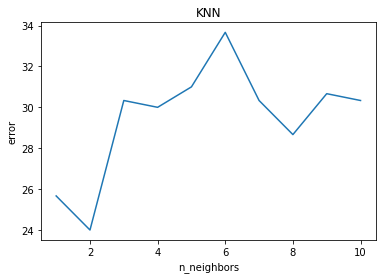

In [95]:
plt.plot(np.arange(1, len(error_list)+1), error_list)
plt.xlabel('n_neighbors')
plt.ylabel('error')
plt.title('KNN')

In [245]:
prediction_KNN, score_KNN, time_KNN = my_KNN(df_train, df_test, 2)
# prediction
error_KNN = sum(prediction_KNN != df_test.iloc[:, -1])
error_KNN

25

In [246]:
error_KNN/len(df_test)

0.0984251968503937

In [247]:
time_KNN

[56.2895, 0.1531]

## Decision Tree:

In [250]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

In [251]:
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [252]:
def get_potential_splits(data):
    
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):          # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [253]:
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above

In [254]:
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy

In [255]:
def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy

In [256]:
def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)

            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

In [257]:
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

In [258]:
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

In [259]:
def classify_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":  # feature is continuous
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return classify_example(example, residual_tree)

In [260]:
def pred_all(test_df,tree):
    predict = []
    for i in range(len(test_df)):
        example = test_df.iloc[i]
        pred = classify_example(example, tree)
        predict.append(pred)
    return predict

In [261]:
tic1 = time.perf_counter()
tree = decision_tree_algorithm(df_train, max_depth=40)
toc1 = time.perf_counter()
time_DT_train = round(toc1-tic1, 4)

In [262]:
tic2 = time.perf_counter()
prediction_DT = pred_all(df_test,tree)
toc2 = time.perf_counter()
time_DT_test = round(toc2-tic2, 4)

In [263]:
error_DT = sum(prediction_DT != df_test.iloc[:, -1])

In [264]:
error_DT

27

In [265]:
time_DT_train

0.3018

# Result:

## Computing time:

In [274]:
print("Naive Bayes running time:")
print("Train:", time_NB[0], 's')
print("Test:", time_NB[1], 's')

Naive Bayes running time:
Train: 0.0079 s
Test: 0.1002 s


In [275]:
print("KNN running time:")
print("Train:", time_KNN[0], 's')
print("Test:", time_KNN[1], 's')

KNN running time:
Train: 56.2895 s
Test: 0.1531 s


In [276]:
print("Decision Tree running time:")
print("Train:", time_DT_train, 's')
print("Test:", time_DT_test, 's')

Decision Tree running time:
Train: 0.3018 s
Test: 0.0441 s


## Accuracy:

In [271]:
print("Naive Bayes accuracy:", round(1-(error_NB/len(df_test)), 4)*100, '%')

Naive Bayes accuracy: 85.83 %


In [272]:
print("KNN accuracy:", round(1-(error_KNN/len(df_test)), 4)*100, '%')

KNN accuracy: 90.16 %


In [273]:
print("Decision Tree accuracy:", round(1-(error_DT/len(df_test)), 4)*100, '%')

Decision Tree accuracy: 89.37 %


## Confusion matrix:

In [109]:
def confusion_M(prediction, observation):
    pre = prediction
    obs = observation
    class_name = np.unique(obs)
    T1 = 0
    F1 = 0
    T2 = 0
    F2 = 0
    for i in range(len(pre)):
        if pre[i] == obs[i]:
            if obs[i] == class_name[0]:
                T1 = T1+1
            else:
                T2 = T2+1
        else:
            if obs[i] == class_name[0]:
                F1 = F1+1
            else:
                F2 = F2+1
    return np.array([[F2,T1],[T2,F1]]), class_name

In [110]:
CM_KNN, class_name_KNN = confusion_M(prediction_KNN, df_test.iloc[:, -1])

In [117]:
CM_NB, class_name_NB = confusion_M(prediction_NB, df_test.iloc[:, -1])

In [267]:
CM_DT, class_name_DT = confusion_M(prediction_DT, df_test.iloc[:, -1])

In [118]:
print("Naive Bayes confusion matrix:")
print("Class name:", class_name_NB)
print(CM_NB)

Naive Bayes confusion matrix:
Class name: ['high risk' 'low risk']
[[ 13  44]
 [174  23]]


In [119]:
print("KNN confusion matrix:")
print("Class name:", class_name_KNN)
print(CM_KNN)

KNN confusion matrix:
Class name: ['high risk' 'low risk']
[[  7  49]
 [180  18]]


In [268]:
print("Decision Tree confusion matrix:")
print("Class name:", class_name_DT)
print(CM_DT)

Decision Tree confusion matrix:
Class name: ['high risk' 'low risk']
[[ 13  53]
 [174  14]]


## Receiver Operating Characteristic:

In [222]:
def ROC(y_test, y_score):
    class_name = np.unique(y_test)
    P = list(y_test).count(class_name[0])
    N = list(y_test).count(class_name[1])
    L = list(zip(y_test, y_score))
    L.sort(key = lambda tup:tup[1])
    FP = 0
    TP = 0
    R = []
    f = -math.inf
    for i in range(len(L)):
        if L[i][1] != f:
            R.append([FP/N, TP/P])
            f = L[i][1]
        if L[i][0] == class_name[0]:
            TP+=1
        else:
            FP+=1
    R.append([FP/N, TP/P])
    return R

In [233]:
R_NB = ROC(df_test.iloc[:,-1], score_NB)

In [234]:
R_KNN = ROC(df_test.iloc[:,-1], score_KNN)

Text(0.5, 1.0, 'ROC Curve of NB')

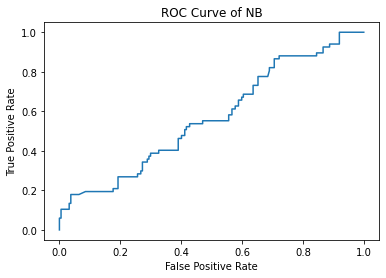

In [237]:
plt.plot(1-np.array(R_NB)[:, 0], 1-np.array(R_NB)[:, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of NB')

Text(0.5, 1.0, 'ROC Curve of KNN')

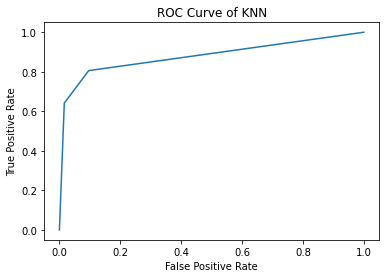

In [239]:
plt.plot(1-np.array(R_KNN)[:, 0], 1-np.array(R_KNN)[:, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNN')